# Predicción de densidad de Enterococcus en playas de São Paulo
<br>
Elaborado por : Luis Felipe Bedoya, Tatiana Arenas Suárez

## Contexto 
Los enterococos son microorganismos anaerobios facultativos grampositivos. El enterococcus faecalis y el enterococcus faecium causan diversas infecciones, entre ellas endocarditis, infecciones urinarias e intraabdominales, prostatitis, celulitis e infecciones de las heridas, así como bacteriemias concurrentes. Se encuentran dentro del grupo de microorganismos indicadores de contaminación fecal de las aguas, y se consideran como el indicador más eficiente para evaluar la calidad del agua de mar para uso recreativo. Teniendo en cuenta que las zonas costeras y sus playas son frecuentadas por turistas que esperan hacer uso de las aguas, se desea estudiar la disponibilidad de las playas en cualquier día del año midiendo la densidad de Enterococos del agua en las playas de São Paulo.

## Información

Los datos de densidad de Enterococcus utilizados fueron muestras tomadas entre 2012 y 2021, de 16 ciudades del litoral de São Paulo y 168 playas. Sin embargo,  solo se analizarán tres playas pertenecientes a la ciudad de São Sebastião. Las estaciones de recolección de muestras se encuentran a 1m de profundidad. Este conjunto de datos pertenecen al CETESB. Esta información fue extraída de: **[Kaggle](https://www.kaggle.com/amandalk/sp-beaches-water-quality)**.

El siguiente mapa muestra el litoral de Sao Paulo al cual pertenecen las ciudades y playas estudiadas.  

<br><br><br>
![Arquitectura](https://gitlab.com/GeoTas/images/-/raw/main/mapa2.png)

## Evaluación

Los valores de la densidad de la bacteria indican la calidad del agua, valores altos indican que el agua está comprometida y representa un riesgo para la salud de los bañistas. Valores mayores a 100 clasifican las aguas de la playa como 'improper' (clase 0) y valores menores de 100 como 'proper' (clase 1).

## Objetivo

Realizar un estudio exploratorio de los datos para verificar la salubridad de las aguas durante el tiempo y construir un modelo de series temporal que permita predecir si las playas serán aptas para el uso de los bañistas.

##Lectura de datos

In [ ]:
storage_account_name = 'waterproject'

In [ ]:
spark.conf.set('fs.azure.account.key.' + storage_account_name + '.blob.core.windows.net', storage_account_access_key)
blob_container = 'project'
filePath = "wasbs://" + blob_container + "@" + storage_account_name + ".blob.core.windows.net/"
pysparkDF = spark.read.format("csv").load(filePath, inferSchema = True, header = True)
pandasDF = pysparkDF.toPandas()

Usando la nube de Azure, se cargan los datos en Databricks y con ayuda de Pyspark se trae la información al notebook.

In [ ]:
# Modulos
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import os

from scipy import stats
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
pandasDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74056 entries, 0 to 74055
Data columns (total 4 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 City 74056 non-null object 
 1 Beach 74056 non-null object 
 2 Date 74056 non-null object 
 3 Enterococcus 74056 non-null float64
dtypes: float64(1), object(3)
memory usage: 2.3+ MB

Los datos cargados contienen cuatro variables:
- **City:** variable categórica con el nombre de la ciudad a la que pertenece la playa
- **Beach:** variable categórica con el nombre de la playa donde se toma la muestra de agua
- **Date:** variable fecha con el año, mes y día en que se toma la muestra de agua
- **Enterococcus:** variable numérica con la densidad de Enteroco medida en la muestra de agua

Estas variables pertenecen a 74056 muestras de agua tomadas en las playas de São Paulo.

In [ ]:
pandasDF['Classify'] = np.where(pandasDF['Enterococcus']>=100, 0, 1)

Para la clasificación de las playas se creo una variable llamada 'Classify' la cual identifica las playas como 'improper' (0) o 'proper' (1). La estructura de la base de datos se muestra a continuación:

In [ ]:
pandasDF.head(5)

Out[186]:

,City,Beach,Date,Enterococcus,Classify
0,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-03,8.0,1
1,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-08,22.0,1
2,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-15,17.0,1
3,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-22,8.0,1
4,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-29,2.0,1


Para el análisis descriptivo se quiere conocer más acerca de las fechas muestreadas, por ello, se toma la variable 'Date' y se divide de la siguiente manera:
- **Weekday:** día de la semana, de 1 (lunes) a 7 (domingo), en que fue tomada la muestra de agua
- **Week:** semana del año en que fue tomada la muestra de agua
- **Day, Month, Year:** fecha separada en que fue tomada la muestra de agua

In [ ]:
import datetime
weekday = []
week = []
day = []
month = []
year = []
for i in range(pandasDF.shape[0]):
  temp = datetime.datetime.strptime(pandasDF.Date[i], "%Y-%m-%d")
  weekday.append(temp.weekday() + 1)
  week.append(datetime.date(temp.year, temp.month, temp.day).isocalendar()[1])
  day.append(temp.day)
  month.append(temp.month)
  year.append(temp.year)
  
pandasDF["Weekday"] = weekday 
pandasDF["Week"] = week
pandasDF["Day"] = day
pandasDF["Month"] = month
pandasDF["Year"] = year

La estructura de la base de datos se muestra a continuación:

In [ ]:
pandasDF.head(5)

Out[188]:

,City,Beach,Date,Enterococcus,Classify,Weekday,Week,Day,Month,Year
0,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-03,8.0,1,2,1,3,1,2012
1,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-08,22.0,1,7,1,8,1,2012
2,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-15,17.0,1,7,2,15,1,2012
3,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-22,8.0,1,7,3,22,1,2012
4,BERTIOGA,BORACÉIA - COL. MARISTA,2012-01-29,2.0,1,7,4,29,1,2012


In [ ]:
print(f"Número de playas: {len(pandasDF.Beach.unique())}") 
print(f"Número de ciudades: {len(pandasDF.City.unique())}")
print("Datos desde {} hasta {}".format(pandasDF.Year.min(), pandasDF.Year.max()))
print("Número de celdas vacías:\n", pandasDF.isnull().sum(axis=0)) 

Número de playas: 168
Número de ciudades: 16
Datos desde 2012 hasta 2021
Número de celdas vacías:
 City 0
Beach 0
Date 0
Enterococcus 0
Classify 0
Weekday 0
Week 0
Day 0
Month 0
Year 0
dtype: int64

Veamos como se comporta la disponibilidad de las playas en todos los periodos muestreados:

Out[190]:

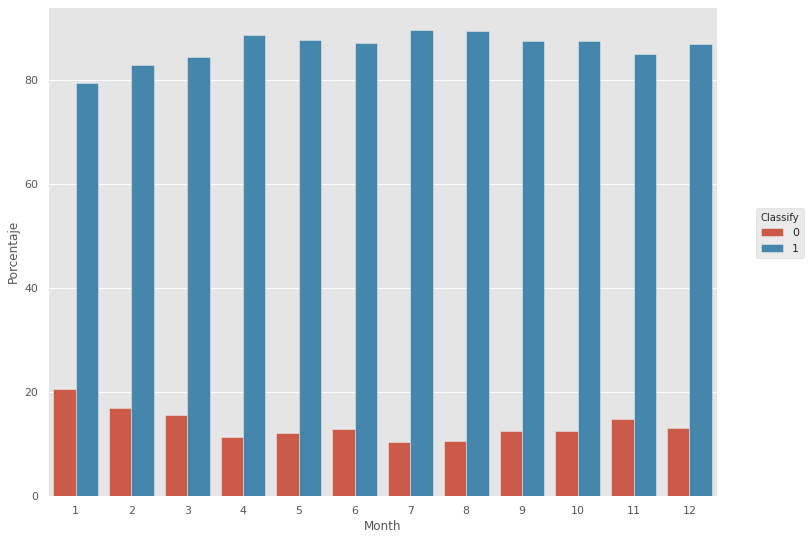

<matplotlib.legend.Legend at 0x7f3e20368850>

In [ ]:
counts = (pandasDF.groupby(['Month'])['Classify']
                     .value_counts(normalize=True)
                     .rename('Porcentaje')
                     .mul(100)
                     .reset_index()
                     .sort_values('Month'))
sns.barplot(x="Month", y="Porcentaje", hue = "Classify", data=counts)
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, title = "Classify")

Se observan dos picos prominentes en enero y noviembre, siendo enero el más alto con casi el 20% lo cual representa aproximadamente 73 días del añó en que las playas de São Paulo no son aptas para los bañistas. En el mes de junio también se alcanza a notar una elevación en la densidad de Enterococcus.

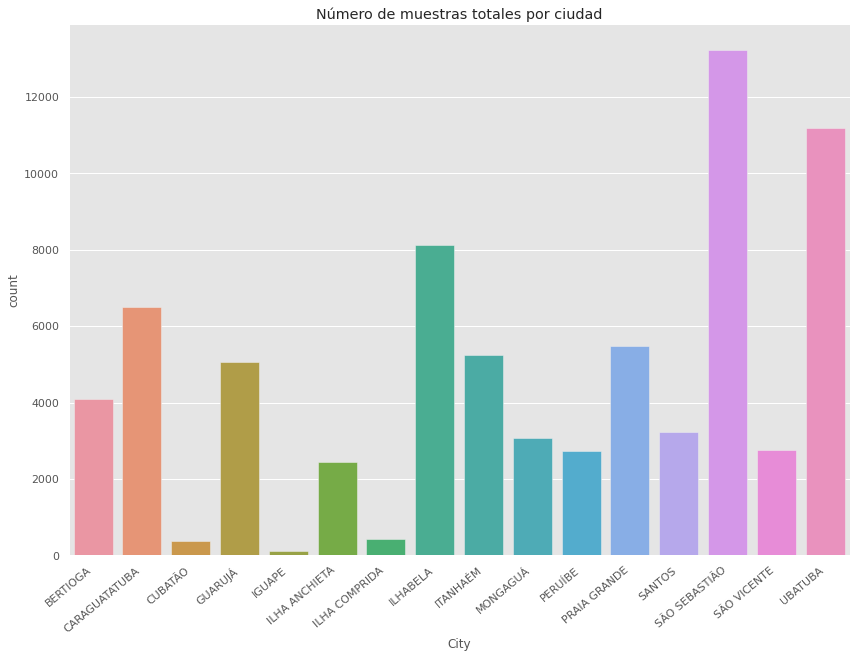

In [ ]:
ax = sns.countplot(x="City", data=pandasDF)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Número de muestras totales por ciudad')
plt.show()

Las muestras en el conjunto de datos se tomaron en 168 playas distintas pertenecientes a 16 ciudades. Para cada ciudad se esperaba igual número de muestras pero no fue así, los investigadores encargados de la toma de los datos parecen tener mayor facilidad para extraer información de algunas playas que de otras, por ejemplo, São Sebastião, Ubatuba y Ilhabela.

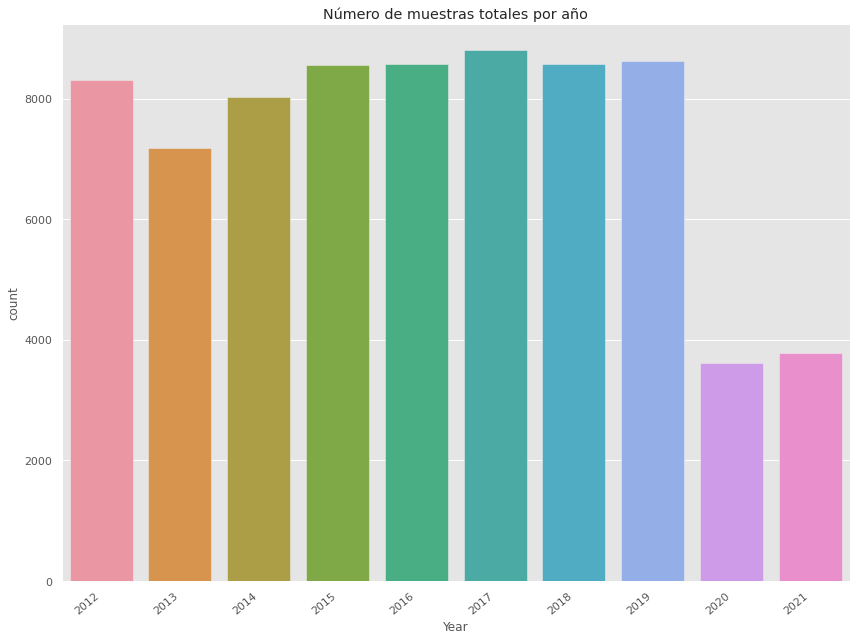

In [ ]:
ax = sns.countplot(x="Year", data=pandasDF)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Número de muestras totales por año')
plt.tight_layout()
plt.show()

Observando la misma información por año tenemos que desde el año 2012 hasta el 2019 se tienen aproximadamente el mismo número de datos, mientras que para el año 2020 y 2021 se tienen un poco menos de la mitad de muestras, esto seguramente se debe a la pandemia de COVID-19 iniciada a principios de 2020.

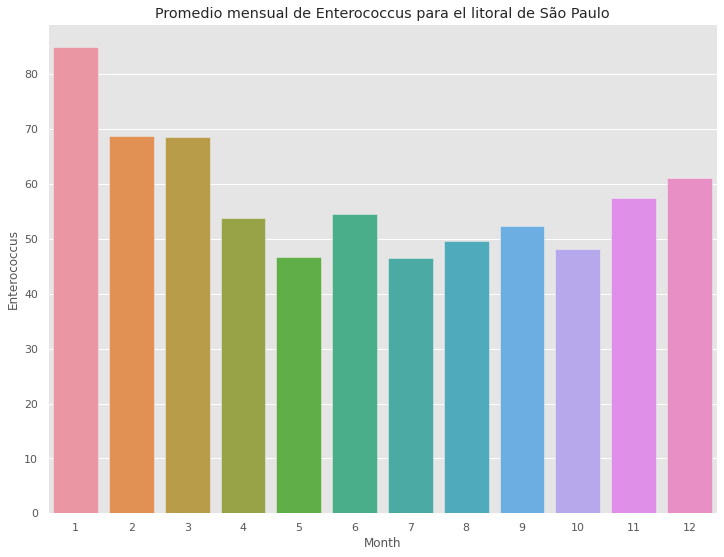

In [ ]:
mbm = pandasDF.groupby(pandasDF['Month'])['Enterococcus'].mean().to_frame().reset_index()
sns.barplot(data=mbm, x="Month", y="Enterococcus")
plt.title('Promedio mensual de Enterococcus para el litoral de São Paulo')
plt.show()

Se ve como existe un periodo, alrededor de 5 meses, desde noviembre hasta marzo en que la densidad promedio de Enterococcus es mayor que en los otros meses. Cabe destacar que en promedio, la densidad de los microorganismos nunca supera el límite para que las playas sean no aptas para bañistas.

Comparando el promedio de Enterococcus con el ciclo de lluvias, se consulta el siguente gráfico de precipitación mensual promedio entre los años 1981-2010 para la zona del litoral de São Paulo. Esta gráfica es suministrada  por el CPTEC/INPE. Cabe anotar que la serie de datos no es suministrada y únicamente se tiene acceso a material gráfico. 


<br><br><br>
![Arquitectura](https://gitlab.com/GeoTas/images/-/raw/e0344087490a806583e6d3a856e7fe409f74c91e/mapa.png)

Se considera que existe un relación entre la proliferación de Enterococcus y la periodicidad de las lluvias, puesto que el comportamiento promedio de las lluvias por meses a través de los años presenta el mismo patrón observado en la gráfica anterior.

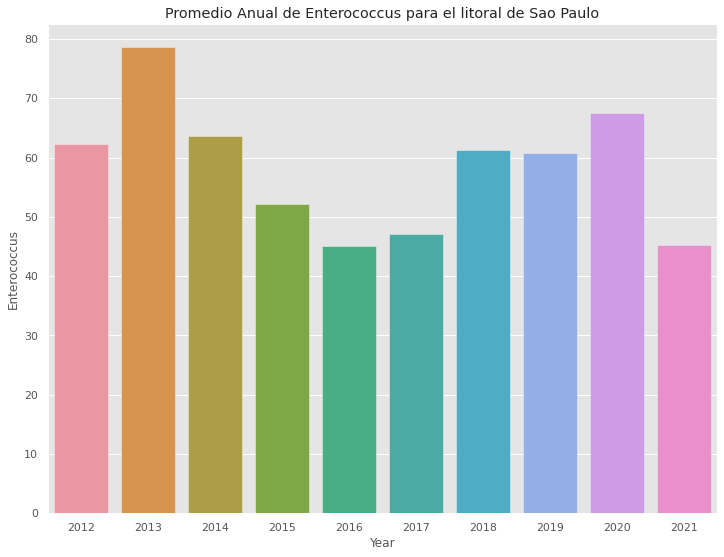

In [ ]:
yby = pandasDF.groupby(pandasDF['Year'])['Enterococcus'].mean().to_frame().reset_index()
sns.barplot(data=yby, x="Year", y="Enterococcus")
plt.title('Promedio Anual de Enterococcus para el litoral de São Paulo')
plt.show()

Por último, el comportamiento promedio del microorganismo a través de los años presenta transiciones de alto a bajo aunque no se puede ver con claridad si existe una periodicidad en este flujo puesto que la cantidad de años medidos no es suficiente.

Con el objetivo de analizar algunas series de datos y hacer predicciónes (forecasting), se seleccionó la ciudad São Sebastião que tiene la mayor cantidad de muestrastomadas y tres de sus treinta playas, estas fueron: Paúba, Santiago y Una.

In [ ]:
# Filtrando datos por São Sebastião
dfSS = pandasDF[pandasDF["City"] == "São Sebastião".upper()]

In [ ]:
print(f"Número de playas en São Sebastião: {len(dfSS.Beach.unique())}") 

Número de playas en São Sebastião: 30

Teniendo en cuenta que los años 2020 y 2021 tienen información átipica del comportamiento de turistas y el uso de playas a causa de la pandemia, estas fechas no se tendrán en cuenta para los análisis respectivos. A continuación se filtra la base de datos:

In [ ]:
dfSS['Date'] = pd.to_datetime(dfSS['Date'])
dfSSf = dfSS[dfSS['Year'] < 2020]
filtro = ["SANTIAGO", "PAÚBA", "UNA"]
dfSS3 = dfSSf[dfSSf['Beach'].isin(filtro)]
dfSS3

Out[197]:

,City,Beach,Date,Enterococcus,Classify,Weekday,Week,Day,Month,Year
5853,SÃO SEBASTIÃO,SANTIAGO,2012-01-03,9.0,1,2,1,3,1,2012
5854,SÃO SEBASTIÃO,SANTIAGO,2012-01-08,8.0,1,7,1,8,1,2012
5855,SÃO SEBASTIÃO,SANTIAGO,2012-01-15,1.0,1,7,2,15,1,2012
5856,SÃO SEBASTIÃO,SANTIAGO,2012-01-22,2.0,1,7,3,22,1,2012
5857,SÃO SEBASTIÃO,SANTIAGO,2012-01-29,3.0,1,7,4,29,1,2012
...,...,...,...,...,...,...,...,...,...,...
64860,SÃO SEBASTIÃO,UNA,2019-12-01,15.0,1,7,48,1,12,2019
64861,SÃO SEBASTIÃO,UNA,2019-12-08,17.0,1,7,49,8,12,2019
64862,SÃO SEBASTIÃO,UNA,2019-12-15,1.0,1,7,50,15,12,2019
64863,SÃO SEBASTIÃO,UNA,2019-12-22,5.0,1,7,51,22,12,2019


Out[198]:

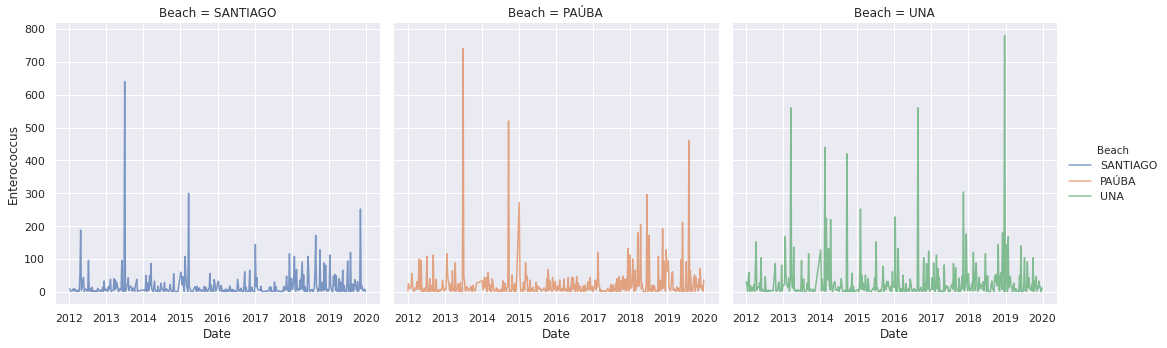

<seaborn.axisgrid.FacetGrid at 0x7f3e185ea5b0>

In [ ]:
sns.set(rc={'figure.figsize':(12,9)})
g = sns.FacetGrid(dfSS3, col="Beach", hue = "Beach", height = 5)
g.map(sns.lineplot, "Date", "Enterococcus", alpha=.7)
g.add_legend()

Gráficamente se tiene que las elevaciones en la densidad de Enterococcus se dan en los últimos y primeros meses de cada año, existen algunos datos en medio de cada año que pueden estar relacionados a algunos factores distinto a las lluvias. Además, en el año 2013 se observó una alta densidad de Enterococcus, también se observa como a partir de 2018 se hizo más frecuente la alta densidad del microorganismo en cada una de las playas. Por otro lado se observa que la playa con menor caliad en sus aguas es Una.

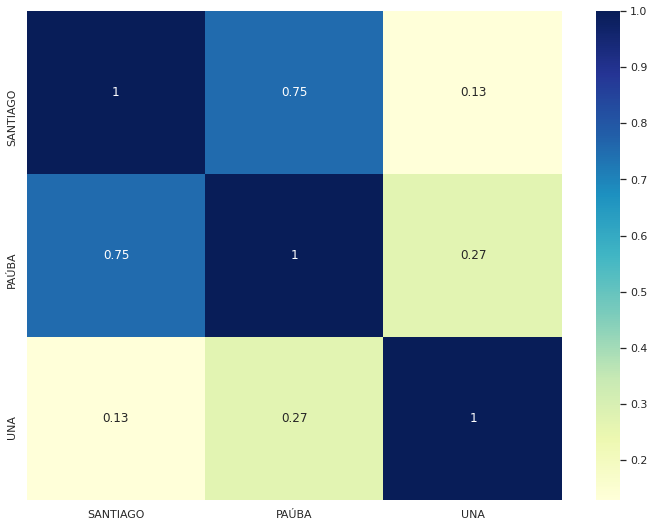

In [ ]:
dfs = dfSS.set_index('Beach')
new = {col: dfs.loc[col,'Enterococcus'].tolist() for col in  ["SANTIAGO", "PAÚBA", "UNA"]}
Corr = pd.DataFrame(data=new)
Corr_map = Corr.corr()
dataplot = sns.heatmap(Corr_map, cmap="YlGnBu", annot=True)

De la matriz anterior, se tiene que existe una corelación alta entre las series de tiempo de Santiago y Paúba e Paúba y Una, mientras que Santiago y Una tienen una correlación cercana a 0. Lo cual era de esperarse puesto que sus ubicaciones determinan estas correlaciones. Santiago y Paúba son playas vecinas, tienen un afluente común que separa las playas llamado Rio Boiçucanga y playa Una está un poco más retirada pero más cerca de Paúba que de Santiago, a playa Una la alimenta un afluente diferente llamado Rio Camburi aunque finalmente todas estas aguas convergen al océano Atlántico, otra razón por la cual aumentan los índices de contaminantes y proliferan microorganismos nocivos para bañistas.

In [ ]:
counts = (dfSS3.groupby(['Month', 'Beach'])['Classify']
                     .value_counts(normalize=True)
                     .rename('Porcentaje')
                     .mul(100)
                     .reset_index()
                     .sort_values('Month'))

Out[201]:

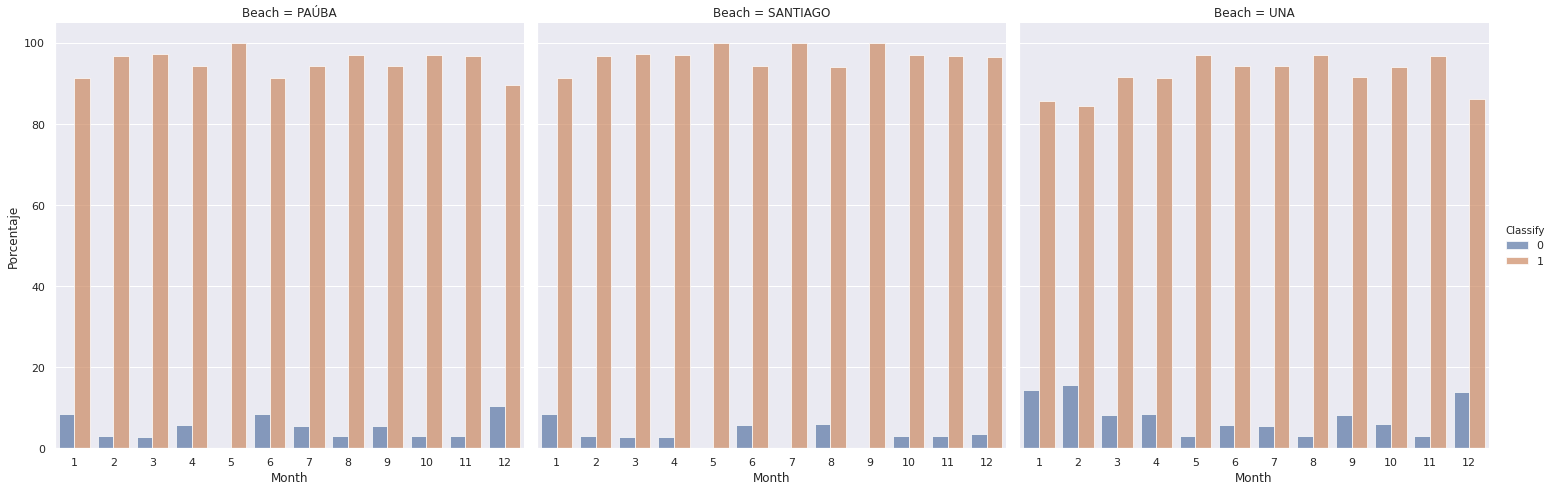

<seaborn.axisgrid.FacetGrid at 0x7f3e18509160>

In [ ]:
sns.catplot(x="Month", y="Porcentaje", data=counts, col="Beach", hue = "Classify", height=7, alpha=.7, kind = "bar")

En las tres playas se observa un patrón similar, densidad de Enterococcus nociva para bañistas en los periodos vacacionales, es decir, en los meses de enero, junio y diciembre, siendo Una la playa con mayor proporción de días de playa apta.

A continuación, se filtra la base de datos por playa de interés:

In [ ]:
SANTIAGO = dfSS3[dfSS3['Beach'] == 'SANTIAGO']
SANTIAGO =  SANTIAGO[['Date','Enterococcus']].set_index('Date')
PAUBA = dfSS3[dfSS3['Beach'] == 'PAÚBA']
PAUBA =  PAUBA[['Date','Enterococcus']].set_index('Date')
UNA = dfSS3[dfSS3['Beach'] == 'UNA']
UNA =  UNA[['Date','Enterococcus']].set_index('Date')

Para predecir el comportamiento del Enterococcus a partir de los datos de 2012-2020 se usará un análisis SARIMA de las series de tiempo. Haciendo uso de Auto ARIMA del modulo 'pmdarima', el procedimiento interno de la función es el siguiente:
- Aplica una transformación Box-Cox, para disminuir varianza y ajustar residuales a una distribución normal estándar
- Aplica la construcción paso a paso de todos los modelos Auto SARIMA que cumplan con las condiciones dadas
- Determina que modelo construído anteriormente tiene el menor AIC

Se usaron los datos para entrenar los modelos desde 2012 hasta 2018 y como conjunto de prueba los datos correspondientes a todo 2019. Finalmente se estimó, el RMSE que corresponde a la raíz cuadrada del error cuadrático medio, el cual está en las mismas unidades de medida que la variable Enterococcus.

In [ ]:
train, test = model_selection.train_test_split(SANTIAGO, train_size=356)
model1 = pm.auto_arima(train.Enterococcus, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=13,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(model1.summary())

SARIMAX Results 
================================================================================
Dep. Variable: y No. Observations: 356
Model: SARIMAX(2, 1, 0, 13) Log Likelihood -1844.659
Date: Mon, 27 Sep 2021 AIC 3695.318
Time: 18:24:15 BIC 3706.832
Sample: 0 HQIC 3699.905
 - 356 
Covariance Type: opg 
==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
ar.S.L13 -0.6590 0.015 -42.752 0.000 -0.689 -0.629
ar.S.L26 -0.3070 0.016 -18.901 0.000 -0.339 -0.275
sigma2 2696.1344 35.608 75.718 0.000 2626.345 2765.924
===================================================================================
Ljung-Box (L1) (Q): 0.03 Jarque-Bera (JB): 61697.05
Prob(Q): 0.86 Prob(JB): 0.00
Heteroskedasticity (H): 0.25 Skew: 5.24
Prob(H) (two-sided): 0.00 Kurtosis: 67.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

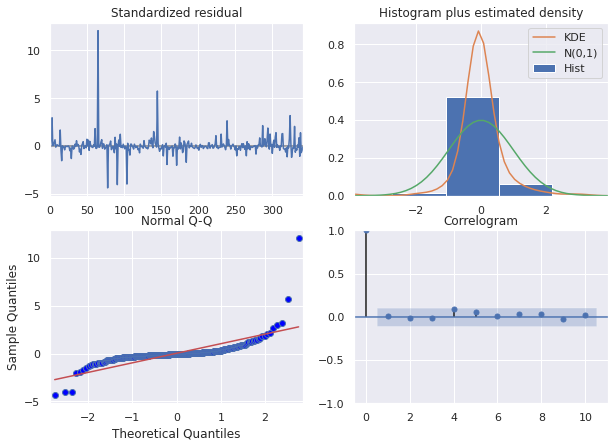

In [ ]:
model1.plot_diagnostics(figsize=(10,7))
plt.show()

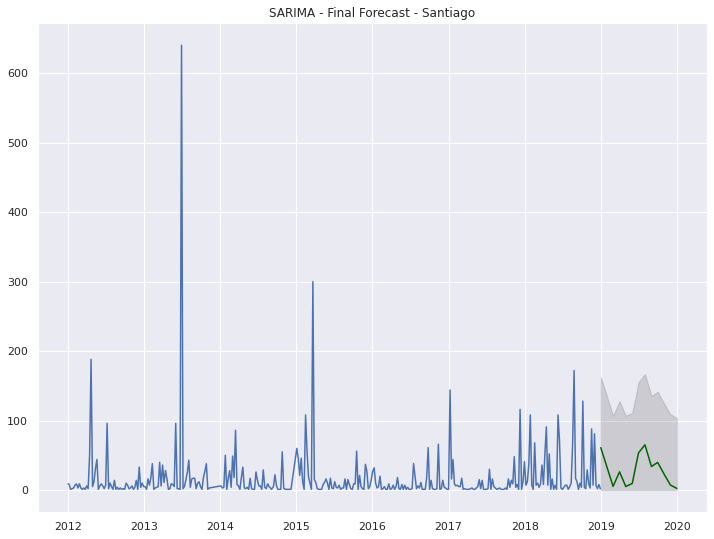

In [ ]:
# Forecast
n_periods = 13
fitted, confint = model1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(0, index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast - Santiago")
plt.show()

In [ ]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test[0:13], fitted)))

Test RMSE: 33.091

El modelo Auto SARIMA(2, 1, 0) construído predijo elevación en la densidad de Enterococcus para inicios de 2019 y de nuevo para junio. El error de las estimaciones está alrededor de 33.1 puntos lo cual podría indicar que en alguna de esas fechas es posible que la densidad del microorganismo supere los límites aptos para bañistas.

In [ ]:
train, test = model_selection.train_test_split(PAUBA, train_size=356)
model2 = pm.auto_arima(train.Enterococcus, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=13,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(model2.summary())

SARIMAX Results 
================================================================================
Dep. Variable: y No. Observations: 356
Model: SARIMAX(2, 1, 0, 13) Log Likelihood -1938.094
Date: Mon, 27 Sep 2021 AIC 3882.188
Time: 18:25:32 BIC 3893.701
Sample: 0 HQIC 3886.774
 - 356 
Covariance Type: opg 
==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
ar.S.L13 -0.6326 0.018 -34.709 0.000 -0.668 -0.597
ar.S.L26 -0.3340 0.019 -17.658 0.000 -0.371 -0.297
sigma2 4649.3341 70.265 66.169 0.000 4511.618 4787.051
===================================================================================
Ljung-Box (L1) (Q): 0.02 Jarque-Bera (JB): 35364.03
Prob(Q): 0.88 Prob(JB): 0.00
Heteroskedasticity (H): 0.41 Skew: 4.70
Prob(H) (two-sided): 0.00 Kurtosis: 51.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

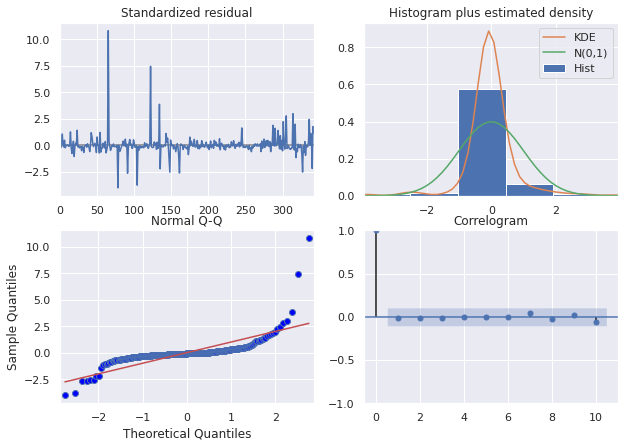

In [ ]:
model2.plot_diagnostics(figsize=(10,7))
plt.show()

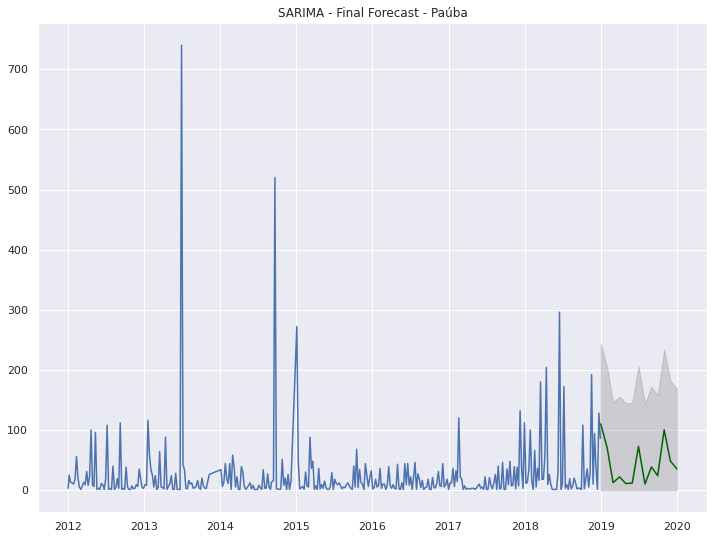

In [ ]:
# Forecast
n_periods = 13
fitted, confint = model2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(0, index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast - Paúba")
plt.show()

In [ ]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test[0:13], fitted)))

Test RMSE: 38.653

El modelo Auto SARIMA(2, 1, 0) construído predijo elevación en la densidad de Enterococcus para inicios de 2019, para junio y para noviembre. Dos de los picos más grandes correspondientes a enero y noviembre superan el límite posible de salubridad. El error de las estimaciones está alrededor de 38.7 puntos lo cual podría indicar que en algunas otras fechas es posible que la densidad del microorganismo supere los límites aptos para bañistas.

In [ ]:
train, test = model_selection.train_test_split(UNA, train_size=356)
model3 = pm.auto_arima(train.Enterococcus, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=13,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(model3.summary())

SARIMAX Results 
================================================================================
Dep. Variable: y No. Observations: 356
Model: SARIMAX(2, 1, 0, 13) Log Likelihood -2022.763
Date: Mon, 27 Sep 2021 AIC 4051.526
Time: 18:26:45 BIC 4063.039
Sample: 0 HQIC 4056.112
 - 356 
Covariance Type: opg 
==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
ar.S.L13 -0.6681 0.034 -19.525 0.000 -0.735 -0.601
ar.S.L26 -0.2940 0.037 -7.890 0.000 -0.367 -0.221
sigma2 7618.3052 154.815 49.209 0.000 7314.873 7921.738
===================================================================================
Ljung-Box (L1) (Q): 1.06 Jarque-Bera (JB): 10385.44
Prob(Q): 0.30 Prob(JB): 0.00
Heteroskedasticity (H): 1.16 Skew: 3.82
Prob(H) (two-sided): 0.43 Kurtosis: 28.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

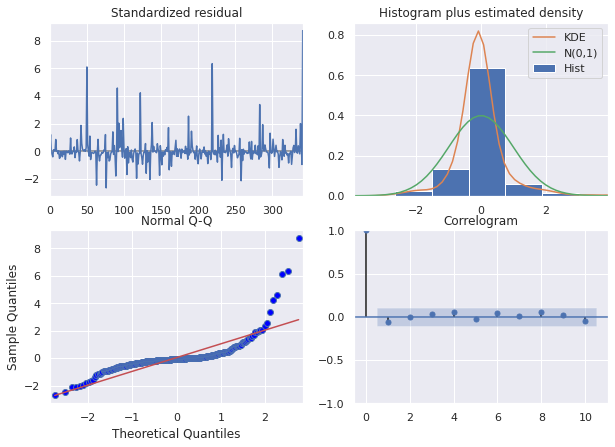

In [ ]:
model3.plot_diagnostics(figsize=(10,7))
plt.show()

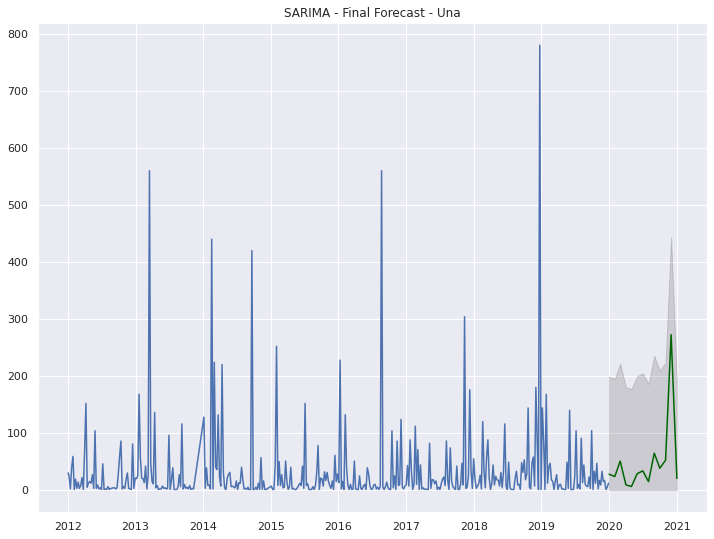

In [ ]:
# Forecast
n_periods = 13
fitted, confint = model3.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(0, index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(UNA)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast - Una")
plt.show()

In [ ]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test[0:13], fitted)))

Test RMSE: 92.483

El modelo Auto SARIMA(2, 1, 0) construído predijo elevación en la densidad de Enterococcus solo para noviembre. El error de las estimaciones está alrededor de 92.5 puntos lo cual podría indicar que en algunas otras fechas es posible que la densidad del microorganismo supere los límites aptos para bañistas.

##Conclusiones 
<br>
1. Las concentraciones promedio anuales de Enterococcus en el periodo de estudio (2012 -2020) siguen el ciclo anual de precipitación de la región litoral de Sao Paulo. En los meses de mayor precipitación aumenta la cantidad de la bacteria en las aguas, resultado que coincide con otros estudios en bahías subtropicales (https://doi.org/10.1128/AEM.01229-20). En el estado de São Paulo el periodo de lluvias, desde noviembre hasta marzo, coincide con el verano y con el comienzo de la época de carnavales a nivel nacional durante el cual las playas tienen una mayor concurrencia, y por lo anterior, mayor peligro para bañistas de ser infectados por Enterococcus.

2. Los meses con mayor incidencia de Enterococcus en el agua para las tres playas son : entre noviembre y febrero, épocas vacacionales. Por esta razón, es importante continuar el monitoreo de las aguas y proponer estratégias para mitigar la contaminación de aguas oceánicas con microorganismos o materiales nocivos para los humanos. 

3. Para realizar un modelo más completo para predecir la prevalencia del Enteroccocus y clasificar mediante un algoritmo de machine learning  las playas como aptas o no aptas  según las características físicas del agua y de sus afluentes,  se necesitan bases de datos con series de tiempo de tipo de mareas, escorrentia , temperatura superficial del mar y precipitación total, las cuales no están disponibles para el público en la actualidad.

4. Predecir estos picos de alta densidad del microorganismo favorecen a los bañistas y permiten redirigir esfuerzos para mitigar la contaminación de afluentes que pueden ser los responsables directos de los incrementos.

## Trabajo futuro

- Con el fin de construir mejores modelos y conseguir estimaciones más precisas se propone utilizar un módulo de machine learning llamado 'orbit-ml' el cual en este proyecto no fue posible usar puesto por errores de compatibilidad con la compilación. Esto con el fin de abandonar supuestos como normalidad que pueden llegar a ser engorrosos en modelos de estadística clásica.

- Realizar un estudio comparativo y la posibilidad de una generalización de un modelo único para describir el comportamiento del Enterococcus en toda la región.

- Se considera que puede existir incremento de la densidad de Enterococcus con el movimiento oceánico, influenciado por tormentas tropicales. Otro factor a considerar en futuros estudios.